## Gradient Exploration Lab

### Step 1: Synthetic Data Generation and Model Initialization

**Objective:** Create a controllable environment to observe how gradients behave under different loss functions. By generating our own data, we know the "ground truth" and can measure how far our model's parameters are from the optimal values.

**Tasks:**
1. **Generate Data**: Create a feature tensor $X$ and a target tensor $y$ with added noise.
2. **Parameter Setup**: Initialize the weight ($w$) and bias ($b$) as tensors that track gradients.
3. **Forward Pass**: Implement the linear operation $\hat{y} = wX + b$.

In [4]:
import torch
# Setting seed for reproducibility
torch.manual_seed(42)

# 1. Generate synthetic data (X and y)
X = torch.randn((100, 1))
true_w = 3.0
true_b = 2.0

# Add Gaussian noise: torch.rand_like(X) generates noise the the same shape as X 
noise = 0.1 * torch.rand_like(X)
y_true = true_w * X + true_b + noise

# 2. Initialize trainable parameters (w and b)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

# 3. Define the forward pass function
def forward(x):
    return w * x + b

y_pred = forward(X)

print(f"Initial w: {w.item():.4f}, Initial b: {b.item():.4f}")

Initial w: -1.2842, Initial b: -0.6917


### Step 2: Comparing Gradients (MSE vs. MAE)

**Objective:** Observe how different loss functions influence the magnitude and behavior of gradients.

**Tasks:**
1. **Mean Squared Error (MSE)**: Compute the MSE loss, perform backpropagation, and record the gradient of $w$.
2. **Mean Absolute Error (MAE)**: Clear the previous gradients, compute the MAE loss, perform backpropagation, and record the new gradient of $w$.
3. **Comparison**: Compare the sensitivity of these two loss functions to outliers and small errors.

In [19]:
def mean_squared_error(y_true, y_pred):
    # Use torch operations to maintain the computational graph
    return torch.mean((y_true - y_pred) ** 2)

def mean_absolute_error(y_true, y_pred):
    # Mean Absolute Error is robust to outliers
    return torch.mean(torch.abs(y_true - y_pred))

# --- MSE Round ---
# 1. Forward pass
y_pred = forward(X) 
mse_loss = mean_squared_error(y_true, y_pred)

# 2. Backward pass (This consumes the graph)
mse_loss.backward()
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"w gradient (MSE): {w.grad.item():.4f}")

# 3. Clear gradients
w.grad.zero_()
b.grad.zero_()

# --- MAE Round ---
# 4. CRITICAL: Re-run forward pass to create a NEW graph
y_pred = forward(X) 
mae_loss = mean_absolute_error(y_true, y_pred)

# 5. Backward pass (This consumes the NEW graph)
mae_loss.backward()
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"w gradient (MAE): {w.grad.item():.4f}")

MSE Loss: 1001539.0625
w gradient (MSE): -122.1566
MAE Loss: 1000.7684
w gradient (MAE): -0.0598


### Step 3: Impact of Outliers on Gradients

**Objective:** Understand the robustness of different loss functions by introducing an outlier into the dataset.

**Tasks:**
1. **Inject Outlier**: Manually modify the first element of `y_true` to an extreme value (e.g., 1000).
2. **Gradient Re-calculation**: Re-run the forward pass and compute gradients for both MSE and MAE.
3. **Analyze**: Observe how the extreme error scales the gradient in MSE versus how it remains constant in MAE.

In [20]:
# --- MSE Round ---
# 1. Forward pass
y_pred = forward(X) 
y_true_outlier = 1000
mse_loss = mean_squared_error(y_true_outlier, y_pred)

# 2. Backward pass (This consumes the graph)
mse_loss.backward()
print(f"MSE Loss: {mse_loss.item():.4f}")
print(f"w gradient (MSE): {w.grad.item():.4f}")

# 3. Clear gradients
w.grad.zero_()
b.grad.zero_()

# --- MAE Round ---
# 4. CRITICAL: Re-run forward pass to create a NEW graph
y_pred = forward(X) 
mae_loss = mean_absolute_error(y_true_outlier, y_pred)

# 5. Backward pass (This consumes the NEW graph)
mae_loss.backward()
print(f"MAE Loss: {mae_loss.item():.4f}")
print(f"w gradient (MAE): {w.grad.item():.4f}")

MSE Loss: 1001539.0625
w gradient (MSE): -122.1566
MAE Loss: 1000.7684
w gradient (MAE): -0.0598


### Step 4: Mathematical Derivation of Gradients (Calculus)

**Objective:** Understand the underlying math behind `.backward()` by deriving the gradients for MSE and MAE using the **Chain Rule**.

#### 1. Mean Squared Error (MSE) Derivation
The loss function is defined as:
$$L_{MSE} = \frac{1}{N} \sum (y_{pred} - y_{true})^2$$
Where $y_{pred} = w \cdot x + b$. To find how the loss changes with respect to $w$, we apply the chain rule:
$$\frac{\partial L}{\partial w} = \frac{\partial L}{\partial y_{pred}} \cdot \frac{\partial y_{pred}}{\partial w}$$

* **Internal derivative**: $\frac{\partial L}{\partial y_{pred}} = \frac{2}{N}(y_{pred} - y_{true})$
* **External derivative**: $\frac{\partial y_{pred}}{\partial w} = x$

**Final MSE Gradient Formula:**
$$\frac{\partial L}{\partial w} = \frac{2}{N} \sum (y_{pred} - y_{true}) \cdot x$$
*Observation:* The gradient is **linear** with respect to the error. If the error is 1000, the gradient will be approximately 2000 times $x$, causing a massive update.

---

#### 2. Mean Absolute Error (MAE) Derivation
The loss function is defined as:
$$L_{MAE} = \frac{1}{N} \sum |y_{pred} - y_{true}|$$
The derivative of an absolute value $|u|$ is the $\text{sign}(u)$ function (which is $1$ if $u > 0$ and $-1$ if $u < 0$).

**Final MAE Gradient Formula:**
$$\frac{\partial L}{\partial w} = \frac{1}{N} \sum \text{sign}(y_{pred} - y_{true}) \cdot x$$

$\text{sign}(y_{\text{pred}} - y_{\text{true}})$ returns 1 if the predicted value is greater than the true value and -1 if smaller, which is the derivative of $|y_{\text{pred}} - y_{\text{true}}|$ with respect to $y_{\text{pred}}$.

*Observation:* The gradient is **constant** relative to the error magnitude. Whether the error is 0.1 or 1000, the "push" given to the weights is the same strength.

---

#### 3. Summary of Gradient Behavior
| Feature | MSE Gradient | MAE Gradient |
| :--- | :--- | :--- |
| **Formula** | $2 \cdot \text{error} \cdot x$ | $\text{sign}(\text{error}) \cdot x$ |
| **Sensitivity** | High (amplifies outliers) | Low (ignores error scale) |
| **Stability** | Smoothly decreases to 0 | Fixed steps (can oscillate near 0) |

### Step 5: Gradient Magnitude vs. Prediction Error

**Objective:** Visualize the relationship between the prediction error ($y_{pred} - y_{true}$) and the resulting gradient magnitude for both MSE and MAE.

**Tasks:**
1. **Simulate Errors**: Create a range of error values from -20 to 20.
2. **Compute Gradients**: Calculate the derivative of MSE ($\frac{d}{de} e^2 = 2e$) and MAE ($\frac{d}{de} |e| = sign(e)$).
3. **Plotting**: Use Matplotlib to plot these derivatives and observe the "V-shape" vs. "Step-function" behavior.

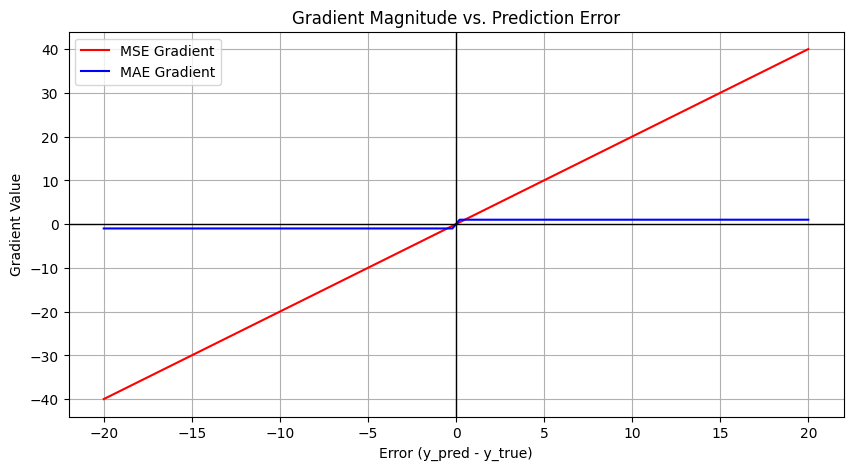

In [17]:
import matplotlib.pyplot as plt

# Simulate errors from -20 to 20
errors = torch.linspace(-20, 20, 100)

# Calculate gradients
# MSE gradient is linear with respect to error: 2 * error
# MAE gradient is constant (sign of error): 1 or -1
grad_mse = 2 * errors
grad_mae = torch.sign(errors)

plt.figure(figsize=(10, 5))
plt.plot(errors.numpy(), grad_mse.numpy(), label='MSE Gradient', color='red')
plt.plot(errors.numpy(), grad_mae.numpy(), label='MAE Gradient', color='blue')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title("Gradient Magnitude vs. Prediction Error")
plt.xlabel("Error (y_pred - y_true)")
plt.ylabel("Gradient Value")
plt.legend()
plt.grid(True)
plt.show()